In [81]:
## numerical and models processing
import torch
import numpy as np
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

import matplotlib.pyplot as plt

import nltk

import sys
sys.path.append('/kaggle/input/utils-trab-compcientifica/')
import utils
import metrics

import plotly.express as px

# Carregamento dos Dados

In [50]:
# Dataframes construídos na análise de dados
test_df = pd.read_pickle('/kaggle/input/utils-trab-compcientifica/df_test_EmailSpam.pkl')
train_val_df = pd.read_pickle('/kaggle/input/utils-trab-compcientifica/df_train_val_EmailSpam.pkl')
print('Test Len:', len(test_df))
print('Train Val Len:', len(train_val_df))

Test Len: 2000
Train Val Len: 31716


In [51]:
# Filtrando casos que não possuem palavras em 'transformed_text'
indexes = []
for i in train_val_df.index:
    if len(train_val_df['transformed_text'][i]) < 1:
        continue
    indexes.append(i)
train_val_df = train_val_df.loc[indexes]

indexes = []
for i in test_df.index:
    if len(test_df['transformed_text'][i]) < 1:
        continue
    indexes.append(i)
test_df = test_df.loc[indexes]

print('Test Len:', len(test_df))
print('Train Val Len:', len(train_val_df))

Test Len: 2000
Train Val Len: 31664


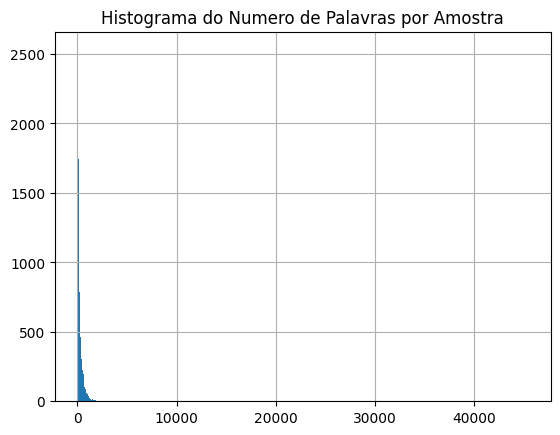

In [52]:
pd.concat([train_val_df, test_df])['num_words'].hist(bins='auto')
plt.title('Histograma do Numero de Palavras por Amostra')
plt.show()

Observamos que a grande maioria dos emails se encontra abaixo de 5000 palavras. Como precisamos de um valor máximo de palavras para o padding que implementaremos para o treinamento em batches. Limitamos os dados para até 5000 palavras.

In [53]:
test_df = test_df[test_df['num_words'] <= 5000]
train_val_df = train_val_df[train_val_df['num_words'] <= 5000]
print('Test Len:', len(test_df))
print('Train Val Len:', len(train_val_df))

Test Len: 1995
Train Val Len: 31568


Agora, a partir das palavras em transformed_text criamos um dicionário para todas as palavras pertencentes ao dataset.

In [54]:
vocab = []
for e, text in enumerate(pd.concat([test_df['transformed_text'], train_val_df['transformed_text']])):
    vocab.extend(text.split())
vocab = sorted(list(set(vocab)))
vocab_dict = {}
for e, i in enumerate(vocab):
    vocab_dict[i] = e+1
vocab_dict[0] = 0

In [55]:
def prepare_sequence(seq, to_ix, n_words):
    idxs = [to_ix[w] for w in seq]
    if len(idxs) < n_words:
       idxs.extend([0]*(n_words-len(idxs)))
    return torch.tensor(idxs, dtype=torch.long)

# Arquiteturas

In [56]:
class Simple_RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,vocab_size, num_layers=1):
        super(Simple_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.words_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.out_layer = nn.Linear(hidden_dim, 1)
    def forward(self, batch):
        seq_lens = [len(c[c!=0]) for c in batch]
        embeds = self.words_embeddings(batch)
        packed = pack_padded_sequence(embeds, seq_lens, batch_first=True, enforce_sorted=False)
        rnn_outs, _= self.rnn(packed)
        seqs, lens = pad_packed_sequence(rnn_outs, batch_first=True)
        y_pred = []
        for e, _ in enumerate(seqs):
            y_pred.append(seqs[e][lens[e]-1])
        y_pred = torch.vstack(y_pred)
        out = self.out_layer(y_pred)
        return out

In [57]:
model = Simple_RNN(32, 4, len(vocab_dict)).to('cuda')
sentence = prepare_sequence(train_val_df['transformed_text'].iloc[0].split(), vocab_dict, 100).to('cuda').unsqueeze(0)
model(sentence)

tensor([[-0.1329]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [58]:
class Simple_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,vocab_size, num_layers=1):
        super(Simple_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.words_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.out_layer = nn.Linear(hidden_dim, 1)
    def forward(self, batch):
        seq_lens = [len(c[c!=0]) for c in batch]
        embeds = self.words_embeddings(batch)
        packed = pack_padded_sequence(embeds, seq_lens, batch_first=True, enforce_sorted=False)
        lstm_outs, _= self.lstm(packed)
        seqs, lens = pad_packed_sequence(lstm_outs, batch_first=True)
        y_pred = []
        for e, _ in enumerate(seqs):
            y_pred.append(seqs[e][lens[e]-1])
        y_pred = torch.vstack(y_pred)
        out = self.out_layer(y_pred)
        return out

In [59]:
model = Simple_LSTM(32, 4, len(vocab_dict)).to('cuda')
sentence = prepare_sequence(train_val_df['transformed_text'].iloc[0].split(), vocab_dict, 5000).to('cuda').unsqueeze(0)
model(sentence)

tensor([[-0.3526]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Torch Dataset

In [60]:
class SPAM_Detection_Dataset(Dataset):
    def __init__(self, df, vocab_dict, max_n_words=5000):
        self.sentences = df['transformed_text'].apply(lambda x: prepare_sequence(x.split(), to_ix=vocab_dict, n_words=max_n_words)).tolist()
        self.labels = df['label'].apply(torch.tensor).tolist()
 
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

In [61]:
from sklearn.model_selection import train_test_split

X = train_val_df.index.tolist()
Y = train_val_df['label'].tolist()
train_idx, val_idx, train_labels, val_labels = train_test_split(X, Y, stratify=Y, test_size=0.25)
train_df = train_val_df.loc[train_idx]
val_df = train_val_df.loc[val_idx]

In [62]:
trainset = SPAM_Detection_Dataset(train_df, vocab_dict)
valset = SPAM_Detection_Dataset(val_df, vocab_dict)
testset = SPAM_Detection_Dataset(test_df, vocab_dict)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, num_workers=4)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=64, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, num_workers=4)

# Training RNN

In [65]:
dev = 'cuda'
model = Simple_RNN(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
model.to(dev)
criterion = nn.BCELoss()

sigmoid = nn.Sigmoid()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
best_loss = 1e10
for epoch in range(10):
    print(epoch)
    running_loss = 0
    #Training
    model.train()
    for sentence, label in trainloader:
        model.zero_grad()
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        loss = criterion(sigmoid(output), label)
        loss.backward()
        optimizer.step()
        running_loss += loss
    train_loss.append((running_loss/len(trainset)).item())
    running_loss = 0

    #Evaluation
    model.eval()
    with torch.no_grad():
        for sentence, label in valloader:
            sentence = sentence.to(dev)
            label = label.to(dev).unsqueeze(1).float()
            output = model(sentence).squeeze(0)
            loss = criterion(sigmoid(output), label)
            running_loss += loss
        val_loss.append((running_loss/len(valset)).item())
        
    #Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        weights = model.state_dict().copy()

torch.save(weights, '/kaggle/working/simple_rnn.pt')

0
1
2
3
4
5
6
7
8
9


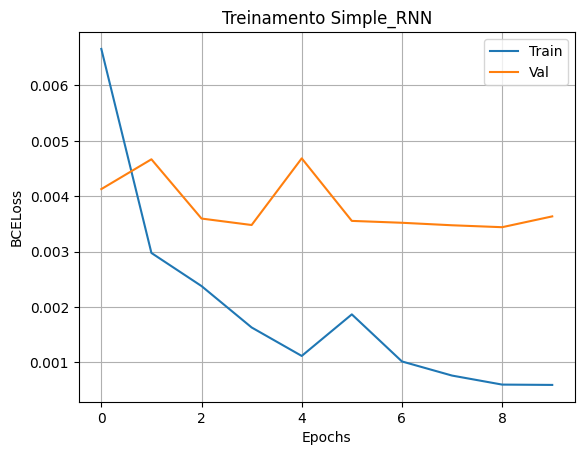

In [68]:
model.load_state_dict(weights)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Treinamento Simple_RNN')
plt.ylabel('BCELoss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

In [72]:
dev = 'cuda'
#model = Simple_RNN(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
#model.load_state_dict(torch.load('/kaggle/input/utils-trab-compcientifica/simple_rnn.pt', weights_only=True))
#model.to(dev)
sigmoid = nn.Sigmoid()
th = 0.5
with torch.no_grad():
    outputs = []
    labels = []
    conf = []
    for sentence, label in valloader:
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        conf.extend(sigmoid(output).cpu())
        outputs.extend((sigmoid(output) > th).cpu().float())
        labels.extend(label.cpu())
print('Acurácia de Validação para Th 0.5: ',(sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())

Acurácia de Validação para Th 0.5:  0.930942714214325


Threshold no ponto ótimo: 0.4560122489929199
Acurácia de Validação com novo Threshold:  0.9334769248962402


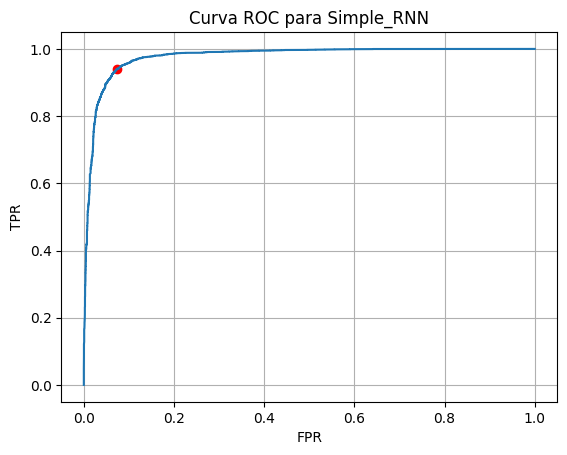

In [71]:
df = pd.DataFrame()
fpr, tpr, thrs = metrics.compute_roc_curve(y_true=torch.tensor(labels), y_probs=torch.tensor(conf))
best_idx = np.argmax(tpr - fpr)
plt.plot(fpr, tpr)
plt.scatter(fpr[best_idx], tpr[best_idx], c='red')
plt.title('Curva ROC para Simple_RNN')
plt.grid()
plt.ylabel('TPR')
plt.xlabel('FPR')

print(f'Threshold no ponto ótimo: {thrs[best_idx].item()}')
outputs = (conf > thrs[best_idx])
print(f'Acurácia de Validação com novo Threshold: ', (sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())
plt.show()

In [74]:
dev = 'cuda'
#model = Simple_RNN(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
#model.load_state_dict(torch.load('/kaggle/input/utils-trab-compcientifica/simple_rnn.pt', weights_only=True))
#model.to(dev)
sigmoid = nn.Sigmoid()
th = 0.4560122489929199
with torch.no_grad():
    outputs = []
    labels = []
    conf = []
    for sentence, label in testloader:
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        conf.extend(sigmoid(output).cpu())
        outputs.extend((sigmoid(output) > th).float().cpu())
        labels.extend(label.cpu())
        
print('Acurácia de Teste: ',(sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())

Acurácia de Teste:  0.932330846786499


# Training LSTM

In [75]:
dev = 'cuda'
model = Simple_LSTM(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
model.to(dev)
criterion = nn.BCELoss()

sigmoid = nn.Sigmoid()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epoch in range(10):
    print(epoch)
    running_loss = 0
    #Training
    model.train()
    for sentence, label in trainloader:
        model.zero_grad()
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        loss = criterion(sigmoid(output), label)
        loss.backward()
        optimizer.step()
        running_loss += loss
    train_loss.append((running_loss/len(trainset)).item())
    running_loss = 0

    #Evaluation
    model.eval()
    with torch.no_grad():
        for sentence, label in valloader:
            sentence = sentence.to(dev)
            label = label.to(dev).unsqueeze(1).float()
            output = model(sentence).squeeze(0)
            loss = criterion(sigmoid(output), label)
            running_loss += loss
        val_loss.append((running_loss/len(valset)).item())
        
    #Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        weights = model.state_dict().copy()

torch.save(weights, '/kaggle/working/simple_lstm.pt')

0
1
2
3
4
5
6
7
8
9


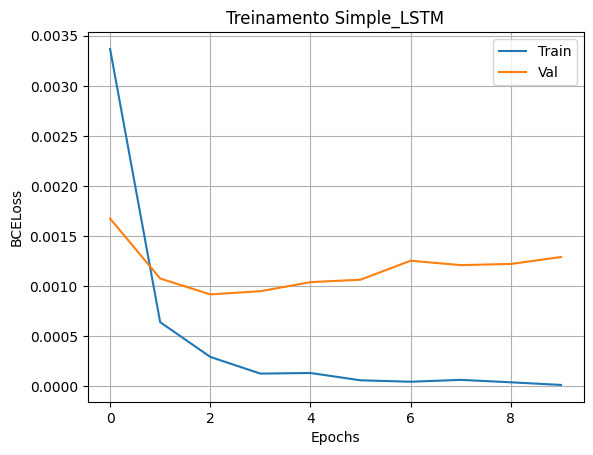

In [76]:
model.load_state_dict(weights)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Treinamento Simple_LSTM')
plt.ylabel('BCELoss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

In [77]:
dev = 'cuda'
#model = Simple_LSTM(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
#model.load_state_dict(torch.load('/kaggle/input/utils-trab-compcientifica/simple_lstm.pt', weights_only=True))
#model.to(dev)
sigmoid = nn.Sigmoid()
th = 0.5
with torch.no_grad():
    outputs = []
    labels = []
    conf = []
    for sentence, label in valloader:
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        conf.extend(sigmoid(output).cpu())
        outputs.extend((sigmoid(output) > th).cpu().float())
        labels.extend(label.cpu())
print('Acurácia de Validação para Th 0.5: ',(sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())

Acurácia de Validação para Th 0.5:  0.9823872447013855


Threshold no ponto ótimo: 0.8040731549263
Acurácia de Validação com novo Threshold:  0.9830207824707031


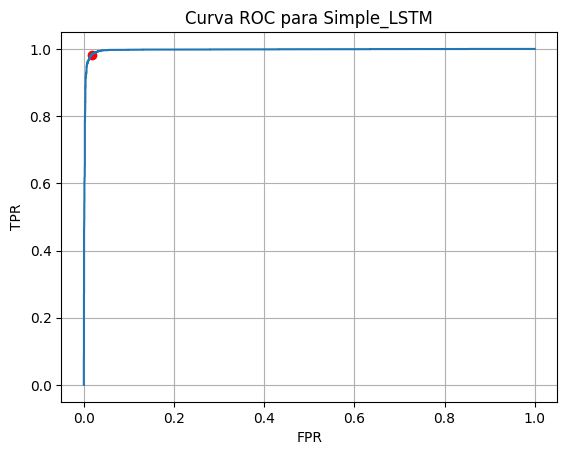

In [78]:
df = pd.DataFrame()
fpr, tpr, thrs = metrics.compute_roc_curve(y_true=torch.tensor(labels), y_probs=torch.tensor(conf))
best_idx = np.argmax(tpr - fpr)
plt.plot(fpr, tpr)
plt.scatter(fpr[best_idx], tpr[best_idx], c='red')
plt.title('Curva ROC para Simple_LSTM')
plt.grid()
plt.ylabel('TPR')
plt.xlabel('FPR')

print(f'Threshold no ponto ótimo: {thrs[best_idx].item()}')
outputs = (conf > thrs[best_idx])
print(f'Acurácia de Validação com novo Threshold: ', (sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())
plt.show()

In [80]:
dev = 'cuda'
#model = Simple_LSTM(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
#model.load_state_dict(torch.load('/kaggle/input/utils-trab-compcientifica/simple_lstm.pt', weights_only=True))
#model.to(dev)
sigmoid = nn.Sigmoid()
th = 0.8040731549263
with torch.no_grad():
    outputs = []
    labels = []
    conf = []
    for sentence, label in testloader:
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        conf.extend(sigmoid(output).cpu())
        outputs.extend((sigmoid(output) > th).float().cpu())
        labels.extend(label.cpu())
        
print('Acurácia de Teste: ',(sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)).item())

Acurácia de Teste:  0.9844611287117004
